In [1]:
device = 'cuda'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [13]:
data = np.load('dataset/terrain_dataset.npy').astype(np.float32)

data -= np.mean(data)
data /= np.std(data)

data = torch.from_numpy(data).float()
print("Initial shape:", data.shape)
data = data.view(-1, 1, 64, 64)
dataset = torch.utils.data.TensorDataset(data)
train, test = torch.utils.data.random_split(dataset, [0.9, 0.1])
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)
print("Final shape:", data.shape)


Initial shape: torch.Size([32645, 64, 64])
Final shape: torch.Size([32645, 1, 64, 64])


In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            # (1) x 64 x 64
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (32) x 32 x 32
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (64) x 16 x 16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (128) x 8 x 8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (256) x 4 x 4
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, latent_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.main(x)

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.ReLU(),
            # (256) x 4 x 4
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (128) x 8 x 8
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (64) x 16 x 16
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # (32) x 32 x 32
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            # (1) x 64 x 64
        )
    
    def forward(self, x):
        return self.main(x)

In [15]:
encoder = Encoder(latent_dim=1024).to(device)
decoder = Decoder(latent_dim=1024).to(device)
criterion = nn.MSELoss()

### Train the Autoencoder

In [34]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0002)

for epoch in range(10):
    for i, data in enumerate(train_loader):
        data = data[0].to(device)

        optimizer.zero_grad()

        latent = encoder(data)
        output = decoder(latent)

        loss = criterion(output, data)
        loss.backward()
        
        optimizer.step()

        print(f'Epoch {epoch}, Batch {i}, Loss {loss.item()}')

Epoch 0, Batch 0, Loss 0.18541468679904938
Epoch 0, Batch 1, Loss 0.13219137489795685
Epoch 0, Batch 2, Loss 0.29206031560897827
Epoch 0, Batch 3, Loss 0.11242373287677765
Epoch 0, Batch 4, Loss 0.05484753102064133
Epoch 0, Batch 5, Loss 0.13701693713665009
Epoch 0, Batch 6, Loss 0.133733332157135
Epoch 0, Batch 7, Loss 0.20578567683696747
Epoch 0, Batch 8, Loss 0.2066982388496399
Epoch 0, Batch 9, Loss 0.23203825950622559
Epoch 0, Batch 10, Loss 0.16472303867340088
Epoch 0, Batch 11, Loss 0.10112777352333069
Epoch 0, Batch 12, Loss 0.14768919348716736
Epoch 0, Batch 13, Loss 0.05574123561382294
Epoch 0, Batch 14, Loss 0.1356288492679596
Epoch 0, Batch 15, Loss 0.12482956796884537
Epoch 0, Batch 16, Loss 0.22229699790477753
Epoch 0, Batch 17, Loss 0.21628116071224213
Epoch 0, Batch 18, Loss 0.017772657796740532
Epoch 0, Batch 19, Loss 0.3732014000415802
Epoch 0, Batch 20, Loss 0.536750853061676
Epoch 0, Batch 21, Loss 0.06932171434164047
Epoch 0, Batch 22, Loss 0.08699695765972137
Epoc

### View an example input and output

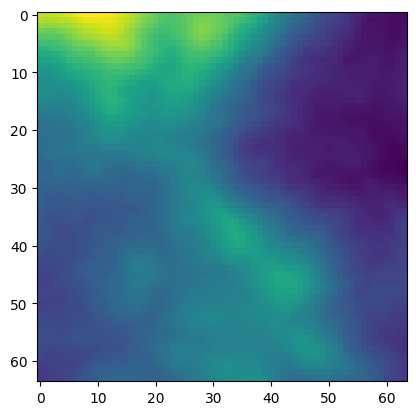

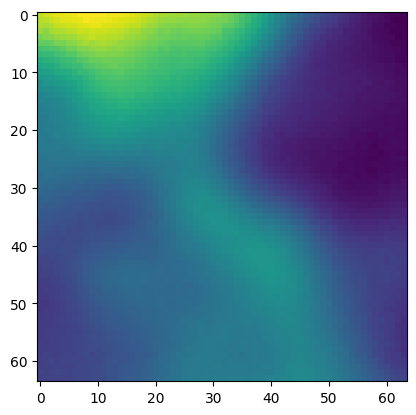

In [44]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    data = next(iter(test_loader))[0].to(device)
    latent = encoder(data)
    output = decoder(latent)

    data = data.cpu().numpy()
    output = output.cpu().numpy()

    plt.imshow(data[0, 0])
    plt.show()
    plt.imshow(output[0, 0])
    plt.show()